# 目的
遺伝子学的分類に基づいた、再発の2値分類を実施する。  

In [1]:
# 基本的なライブラリ
import os
from tqdm import tqdm
import warnings

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 50)

import matplotlib.pyplot as plt

%matplotlib inline

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

# モデル
from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.svm import FastKernelSurvivalSVM
from sksurv.linear_model import IPCRidge


# 評価指標
from sksurv.metrics import (
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,
)

import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

# データ全体での予測モデル検証

## ベースモデルの学習結果

各特徴量選択されたdfを用いて基本的な2値分類モデルを学習する

In [2]:
def save_model_pipeline(
    pipeline: callable,
    val_step: str,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    pipeline_path = "{0}/{1}".format(save_file_path, val_step)
    functions.make_dir(pipeline_path)
    functions.pickle_dump(pipeline, "{0}/model_pipeline.pkl".format(pipeline_path))

In [3]:
def exists_pipeline(path: str) -> bool:
    return os.path.exists(path)

In [4]:
def plot_step_funcs(funcs, label=None, xlabel=None, ylabel=None):
    for fn in funcs:
        plt.step(fn.x, fn(fn.x), where="post", label=label)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

In [5]:
def validate_model(
    model_order: dict = {"original_data": []},
    val_step="val_set",
    input_data_path: str = None,
    output_pipe_path: str = None,
    is_fitted: bool = False,
):
    try:
        _X_train = pd.read_pickle(
            "{0}/{1}/train/X.pkl".format(input_data_path, val_step)
        )
        _y_train = pd.read_pickle(
            "{0}/{1}/train/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
        _X_test = pd.read_pickle("{0}/{1}/test/X.pkl".format(input_data_path, val_step))
        _y_test = pd.read_pickle(
            "{0}/{1}/test/y.pkl".format(input_data_path, val_step)
        ).to_records(index=False)
    except:
        print("data pkl file dose not exist")
        return pd.DataFrame()

    # display(_X_train.shape, _y_train.shape)
    # display(_X_test.shape, _y_test.shape)
    if _X_train.shape[0] < 20:
        return

    pipeline_path = "{0}/{1}".format(output_pipe_path, val_step)
    if exists_pipeline(pipeline_path) and is_fitted:
        # 学習済みパイプラインの使用
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(pipeline_path)
        )
    else:
        # パイプラインの学習の実施
        _model_pipeline = Pipeline(steps=model_order)
        _model_pipeline.fit(_X_train, _y_train)
    _estimator = _model_pipeline[-1]

    # c-index
    _train_score = _estimator.score(_X_train, _y_train)
    _test_score = _estimator.score(_X_test, _y_test)

    _risk_test = _model_pipeline.predict(_X_test)
    print(_risk_test)
    va_times = np.arange(
        pd.DataFrame(_y_test).RFS_MONTHS.min(),
        pd.DataFrame(_y_test).RFS_MONTHS.max(),
        1,
    )
    # cumulative/dynamic auc
    _cph_auc, _cph_mean_auc = cumulative_dynamic_auc(
        _y_train, _y_test, _risk_test, va_times
    )
    print(_cph_mean_auc)

    # 累積AUCの表示
    plt.subplot(1, 1, 1)
    plt.plot(va_times, _cph_auc, label=_estimator.__class__.__name__)
    plt.xlabel("months from surgery")
    plt.ylabel("time-dependent AUC")
    plt.xlim(0, 250)
    plt.ylim(0, 1)
    plt.grid(True)
    plt.legend()

    """
    # plot survival funcs
    _surv_funcs_test = _model_pipeline.predict_survival_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 2)
    plot_step_funcs(
        funcs=_surv_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="surv rate",
    )

    # テストデータ患者のハザード率のプロット
    _chf_funcs_test = _estimator.predict_cumulative_hazard_function(
        _X_test[0].reshape(1, -1)
    )
    plt.subplot(1, 3, 3)
    plot_step_funcs(
        funcs=_chf_funcs_test,
        label=_estimator.__class__.__name__,
        xlabel="months from surgery",
        ylabel="hazard rate",
    )
    """

    df_score = pd.DataFrame(
        [_train_score, _test_score, _cph_mean_auc],
        index=[
            "train c-index",
            "test c-index",
            "AUC mean",
        ],  # "Integrated Brier Score"],
        columns=[_estimator.__class__.__name__],
    ).round(3)

    if output_pipe_path:
        save_model_pipeline(
            pipeline=_model_pipeline,
            val_step=val_step,
            save_file_path=output_pipe_path,
        )
    return df_score

In [6]:
def loop_exec():
    # 層別化する特徴量
    subgroup_columns = [
        "CLAUDIN_SUBTYPE",
        # "THREEGENE",
    ]
    # 遺伝子発現量以外の特徴量を削除
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    val_step = "test_set"

    for subgroup_column in subgroup_columns:  # 各サブグループへの適用
        for subgroup in df_recurrenced[subgroup_column].unique():  # サブグループの要素毎への適用
            # print("subgroup: ", subgroup)
            # init each loop
            plt.figure(figsize=(6, 6))
            df_scores = pd.DataFrame(
                index=["train c-index", "test c-index", "AUC mean"]
            )

            for model_order_dict in model_order_dicts:
                input_data_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                output_pipe_path = "./{0}/{1}/{2}/{3}/{4}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                    model_order_dict["model_name"],
                )
                df_score = validate_model(
                    model_order=model_order_dict["model_order"],
                    val_step=val_step,
                    input_data_path=input_data_path,
                    output_pipe_path=output_pipe_path,
                    is_fitted=False,
                )
                df_scores = pd.merge(
                    df_scores, df_score, right_index=True, left_index=True
                )

            try:
                output_result_path = "./{0}/{1}/{2}/{3}".format(
                    config.INTERIM_MODELS_RECURRENCE_DIR,
                    subgroup_column,
                    subgroup,
                    model_order_dict["preprocess_name"],
                )
                functions.make_dir(output_result_path)
                df_scores.to_csv(output_result_path + "/result.csv")
            except:
                pass

            output_fig_path = "./{0}/{1}/{2}/{3}".format(
                config.FIGURES_MODELS_RECURRENCE_DIR,
                subgroup_column,
                subgroup,
                model_order_dict["preprocess_name"],
            )
            functions.make_dir(output_fig_path)
            # plt.close()
            plt.title(subgroup)
            plt.savefig(output_fig_path + "/auc.png")
            plt.show();

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
[ 0.05253894  0.27711968  0.05909684  0.16092021 -0.15447352  0.1226849
  0.09643986  0.05732955 -0.17380842 -0.086355    0.29511945 -0.07274576
 -0.64612626  0.00591195  0.19803335  0.1831835  -0.04287421  0.02613022
 -0.22181623  0.03812114 -0.0118907   0.15015672]
nan
[-0.66462255  2.21593867 -1.27814462  1.45696547  2.76449852  2.24821757
  0.99409939 -0.20190022  1.84563881 -1.4872144  -1.10543151 -0.22740884
 -2.86862002 -2.4994759   3.28540206  2.06111759 -0.85222293 -2.29601687
 -1.24969264 -2.80664965  2.56744705 -0.203028  ]
nan
[10.34389083 15.47776345  9.18368244 12.28327132 12.99126024 20.26970494
 19.14232742 13.75790386 14.6725671   8.45743824 14.7695507  12.58544874
  9.1662956   9.27466479 19.86114838 17.77432133 10.12537679  7.37085204
  9.03789928  7.00377141 12.41303757 11.95612519]
nan
[11.00154707 11.63567321 11.58494801 11.41334411 11.83252661 12.62763233
 12.7

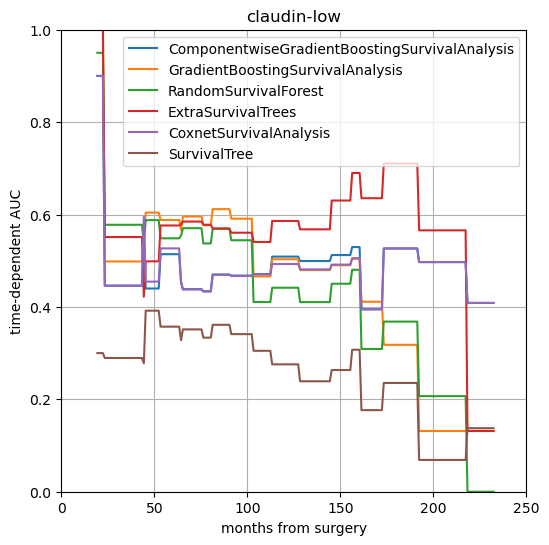

[ 1.41548396e-01 -1.81134204e-01 -4.26669940e-01 -5.24533848e-01
 -7.01998083e-01  1.76260031e-01 -4.76898369e-01  2.99046888e-01
  1.51288839e-01  1.83602183e-01  1.35838620e-01  2.39240889e-01
  3.76321780e-01  1.67816595e-01  4.01096408e-01  1.42215642e-02
 -1.76350272e-03  1.63831052e-01  9.45757573e-02 -4.39423930e-01
  1.22803576e-01 -3.72413349e-01 -2.26285000e-01  2.42853902e-04
  3.48186577e-01  3.43065278e-01 -3.93788301e-01  1.39025943e-01
 -9.71343398e-02  3.53303760e-01 -2.17754354e-02  1.68734288e-01
  2.25862069e-01  5.01197175e-01  1.39473348e-01  4.01306260e-01
  6.51286446e-01 -2.94654870e-02 -7.95559727e-02 -3.37967554e-01
 -1.21634874e+00  7.43096825e-01  3.87681925e-01  3.51043153e-01
  1.46024352e-01  1.27742570e-01  6.89603980e-01  1.73271437e-02
  1.78894597e-01 -9.70771395e-02 -7.36440273e-02 -2.09238182e-02
  3.54850106e-01  5.84285993e-02  5.83731155e-02 -2.15369773e-01
  7.80577893e-01  3.59635203e-01 -4.55614702e-01 -1.93827697e-01
  9.89725323e-02  4.09078

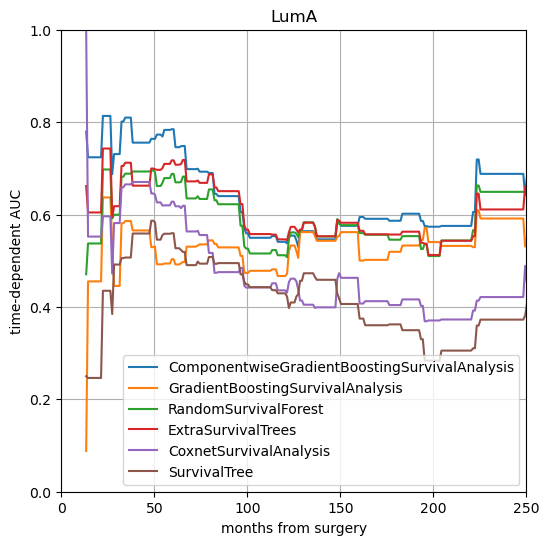

[ 0.18104166 -0.13447904 -0.02385989  0.06928453  0.41891291  0.25632021
 -0.38733598  0.14212277  0.0077259  -0.15544336 -0.08368237  0.30429734
  0.22184544  0.55171643  0.46937854  0.11824565 -0.48069494 -0.1401961
  0.18876955 -0.05965692 -0.29652266  0.18305769 -0.1680823   0.20062719
  0.18549993  0.05917943 -0.32035405 -0.10262086 -0.23625839 -0.24182704
 -0.39685684 -0.37131091 -0.655832   -0.01496887 -0.08275193 -0.03517205
 -0.13317837  0.31559088 -0.09686998 -0.02916685 -0.18664018 -0.04913665
  0.09309544  0.09680812 -0.4001132  -0.71223789 -0.62659186 -0.77189219]
0.5443606032610725
[ 0.21272752 -0.32215311  0.16630748  1.95577856  1.73925862  1.10195455
 -2.35054023 -0.77763882  0.22647233 -0.83464356 -1.2345083  -0.52626951
  0.30845814  1.25271463  2.14934873  0.12254638  0.09900431 -0.95840483
 -0.95572728  0.18676354 -1.78891759  2.06126708 -2.20312203  1.02742418
 -0.52351517 -0.55597651 -1.24912631 -0.56826564  1.00977876 -0.88503086
  1.18006631 -0.59179171 -0.6182

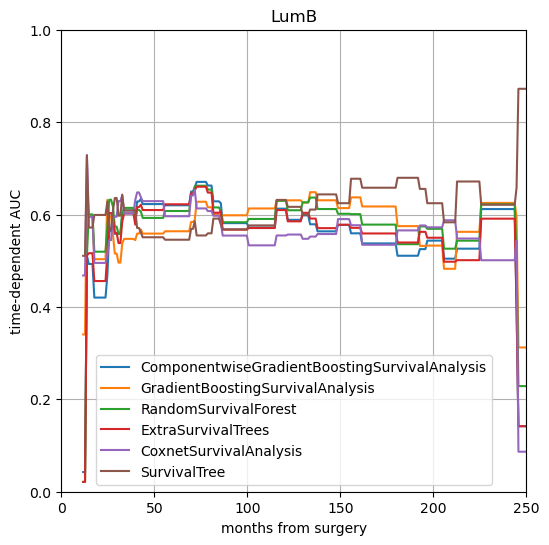

[ 0.17025331  0.00985826 -0.01559896  0.21647991  0.21302005  0.24711725
  0.2159619   0.12055806  0.40689751  0.3704423  -0.21291161  0.02666842
  0.25551027  0.24683311 -0.33339498]
0.8014842662814234
[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296
[17.18268391 18.61061663 20.78489951 18.0800376  24.01117111 25.7151519
 21.02039673 23.20437267 21.44261587 22.36803299 16.47793233 21.37239899
 17.25878139 27.00359172 11.24637626]
0.6646095833528781
[17.27821573 17.2531533  17.45063382 17.0741271  17.80259345 17.92667235
 17.28947502 17.60593604 17.5917726  18.06456857 16.88075682 17.60969617
 17.65056954 17.98295851 16.5481636 ]
0.7697628175020238
[ 0.12917912  0.01478206  0.05644342  0.15077612  0.16022692  0.17267514
  0.17907196  0.15013044  0.31629144  0.25281595 -0.15884705 -0.01930486
  0.15280241  0.19593911 -0.19971379]
0.7856

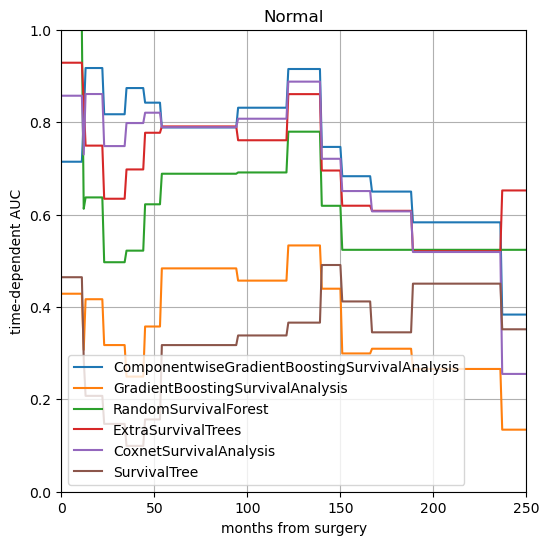

[ 0.03822217 -0.18956666 -0.21614016  0.35285688 -0.15018836  0.33262738
  0.03943221  0.00744449  0.15953965  0.07973494 -0.26250567 -0.162498
  0.31840129  0.00115233  0.39298571  0.20365396 -0.11671431 -0.18887221
 -0.45386278 -0.32089696  0.50607091 -0.0844501  -0.0626447 ]
0.5191940661649357
[ 1.40725591  1.13309912  0.55925108  2.14999787 -1.51222863  0.08313924
  2.56049594  1.01472909  0.95363546  0.37068482 -1.67442125 -0.83530815
 -0.69031091  2.60699199  0.70609471  2.18912513 -3.73262535  1.48715848
 -0.22032686  1.32165122  3.32608954  0.91803196 -0.7619596 ]
0.42143877782353695
[37.88238228 26.11092552 29.80663138 51.69806783 26.67738494 49.4621798
 47.55476784 34.15050277 47.30869241 45.67486879 32.46105775 31.29489228
 45.90931519 36.89615116 51.6172008  45.63351424 28.11956489 33.47401318
 22.88695636 26.91518355 47.78390395 35.06550322 32.91896298]
0.525834928853142
[34.62490699 32.91446253 32.82742013 37.70379346 31.95881375 37.70374729
 35.73056082 34.64406533 35.87

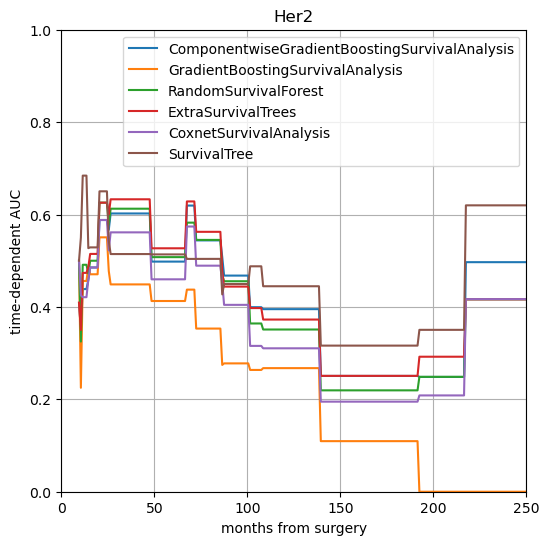

[ 0.16696584  0.11105486  0.08910636 -0.17272522 -0.10174815  0.28996644
  0.28156104 -0.26572037  0.14504998  0.02285072  0.1066515   0.23229862
  0.36157555  0.14937553 -0.20992749 -0.52879718 -0.1255898   0.14752158
  0.31593046  0.13231414  0.08108931]
0.3818245880741024
[ 2.39371847 -1.95690802  3.07793154  0.45011248 -1.60195125  1.95873301
  2.05258992  1.04614168  0.69842646  3.49879398  2.91634457  1.19788375
  2.67621899 -0.24916021 -1.64516808 -3.73531453 -1.22339289 -0.5892542
 -1.64226957 -0.52934173  2.09266045]
0.5093594896890004
[32.9259614  24.9423187  27.10399096 16.12897486 16.70802234 29.89572506
 25.40562515 21.31827669 24.45299801 28.35832106 27.93575652 28.34981693
 31.05072048 26.23626812 17.67596854 13.5467919  20.59040676 19.90397923
 19.77869617 22.92406843 24.38789747]
0.4803826466207158
[23.69074715 23.22705013 22.92703985 21.85179908 21.8176073  23.38966153
 23.12472653 22.1969332  23.07882757 23.56945987 22.72789016 23.57758193
 23.75474225 22.90469535 21

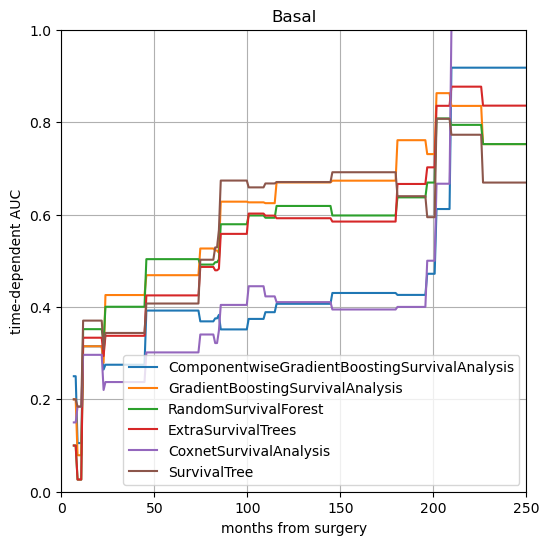

data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist
data pkl file dose not exist


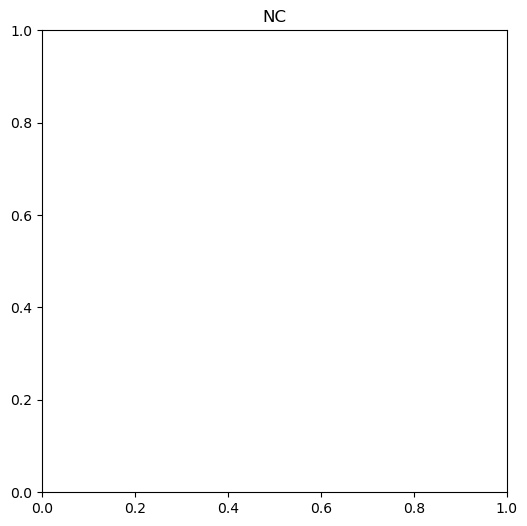

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [08:51<00:00, 531.41s/it]


In [7]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(25, 26, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
                    ComponentwiseGradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": RandomSurvivalForest().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    RandomSurvivalForest().__class__.__name__,
                    RandomSurvivalForest(
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
        {
            "model_name": ExtraSurvivalTrees().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    ExtraSurvivalTrees().__class__.__name__,
                    ExtraSurvivalTrees(
                        random_state=config.SEED,
                        n_estimators=1000,
                        min_samples_split=10,
                        min_samples_leaf=15,
                        n_jobs=-1,
                    ),
                ),
            ],
        },
        {
            "model_name": CoxnetSurvivalAnalysis().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    CoxnetSurvivalAnalysis().__class__.__name__,
                    CoxnetSurvivalAnalysis(n_alphas=10000, fit_baseline_model=True),
                ),
            ],
        },
        {
            "model_name": SurvivalTree().__class__.__name__,
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    SurvivalTree().__class__.__name__,
                    SurvivalTree(random_state=config.SEED),
                ),
            ],
        },
    ]
    loop_exec()

  0%|                                                                                             | 0/1 [00:00<?, ?it/s]

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
25
[-0.66462255  2.21593867 -1.27814462  1.45696547  2.76449852  2.24821757
  0.99409939 -0.20190022  1.84563881 -1.4872144  -1.10543151 -0.22740884
 -2.86862002 -2.4994759   3.28540206  2.06111759 -0.85222293 -2.29601687
 -1.24969264 -2.80664965  2.56744705 -0.203028  ]
nan


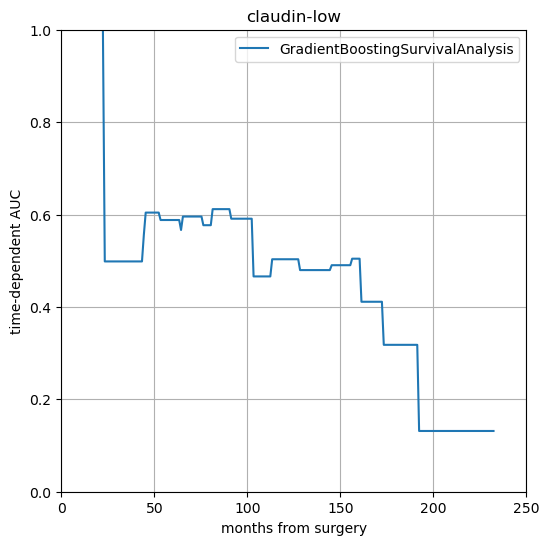

[ 0.81910423 -0.58484384 -0.95913604 -2.3018112  -1.56219809  0.93250135
 -0.87327243  0.18564002  1.24442024 -1.60999113 -1.11712956  2.30353038
 -1.07234573 -0.56338571  0.997924    0.19621639 -0.22702751 -0.58399148
 -0.59322856 -0.40849774  0.150178    0.34805239 -1.04583902  0.01108529
 -1.15205004 -1.0375639  -1.40658384  0.36876524 -1.10959613 -0.15994638
 -0.75289425  1.41856061  0.19988859  0.42653582 -1.91445271  1.0826289
  1.13647902  0.68285639 -0.91364155 -0.58096935 -0.15365437  1.90693158
 -1.1438139   0.81236534  0.2808322   1.00886652  2.19417591 -0.06582985
  1.79697927  0.66783837 -0.53980943  0.43501183 -0.23700754  0.20409208
  1.14055457  0.7487561   0.83525018  0.32674783 -0.16347896  0.54179485
  0.31249431  0.67059009  1.06305821  0.52812711 -1.06762411 -0.38313419
 -0.74068467 -0.07845838 -1.64923572]
0.553528597095901


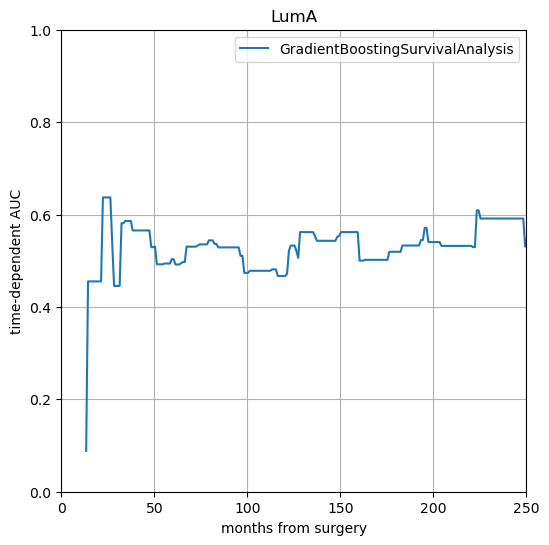

[ 0.21272752 -0.32215311  0.16630748  1.95577856  1.73925862  1.10195455
 -2.35054023 -0.77763882  0.22647233 -0.83464356 -1.2345083  -0.52626951
  0.30845814  1.25271463  2.14934873  0.12254638  0.09900431 -0.95840483
 -0.95572728  0.18676354 -1.78891759  2.06126708 -2.20312203  1.02742418
 -0.52351517 -0.55597651 -1.24912631 -0.56826564  1.00977876 -0.88503086
  1.18006631 -0.59179171 -0.61821216  0.56563572  1.23211081 -0.73985139
  0.4253579   1.13998159  1.36037395 -2.1209076   0.96268123  1.31579767
  1.9802607  -1.4817713  -1.96119203 -2.48570887 -1.00842367 -0.51876672]
0.5722118189801356


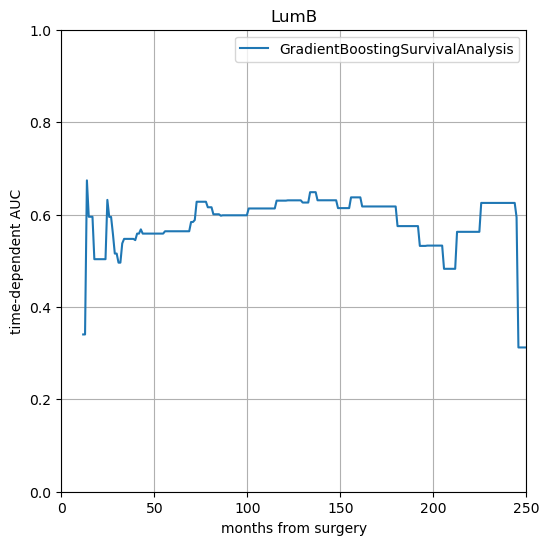

[-2.74586825  0.79271704  0.94862012 -0.20646466  1.61869153  3.71285891
  1.72388903  3.44547571  0.83350567 -3.24895976 -1.44422991  0.3896396
 -2.6641052   0.33596574 -3.42015561]
0.3964429455780296


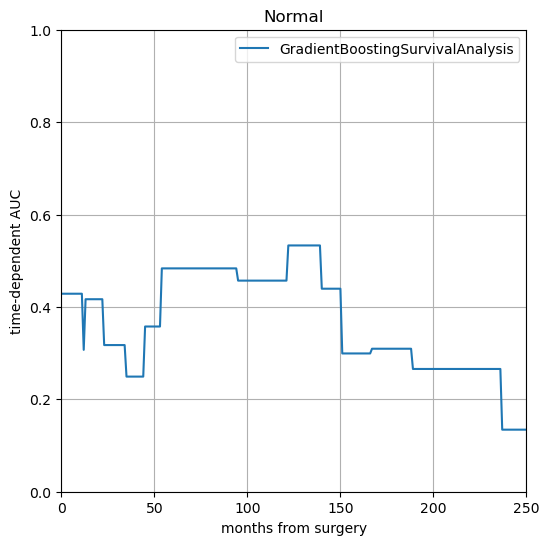

[ 1.40725591  1.13309912  0.55925108  2.14999787 -1.51222863  0.08313924
  2.56049594  1.01472909  0.95363546  0.37068482 -1.67442125 -0.83530815
 -0.69031091  2.60699199  0.70609471  2.18912513 -3.73262535  1.48715848
 -0.22032686  1.32165122  3.32608954  0.91803196 -0.7619596 ]
0.42143877782353695


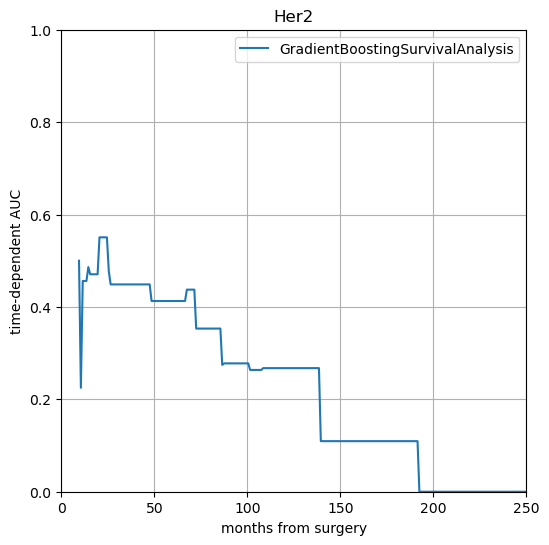

[ 2.39371847 -1.95690802  3.07793154  0.45011248 -1.60195125  1.95873301
  2.05258992  1.04614168  0.69842646  3.49879398  2.91634457  1.19788375
  2.67621899 -0.24916021 -1.64516808 -3.73531453 -1.22339289 -0.5892542
 -1.64226957 -0.52934173  2.09266045]
0.5093594896890004


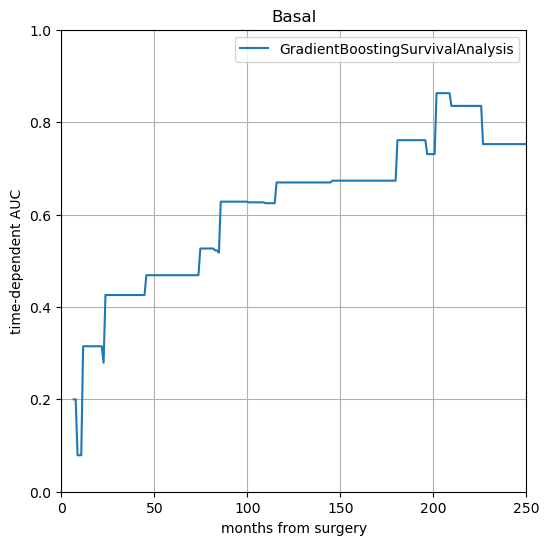

data pkl file dose not exist


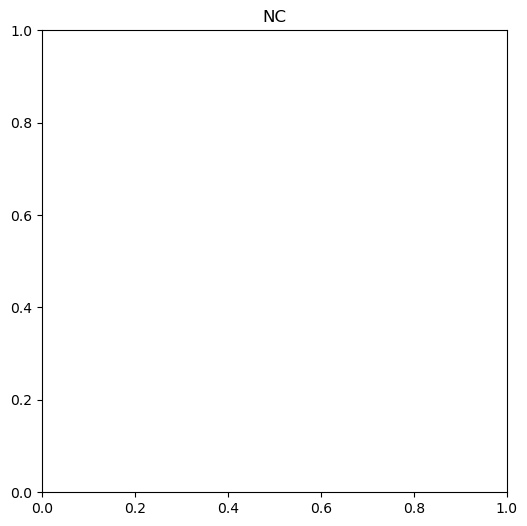

100%|█████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:08<00:00,  8.68s/it]


In [8]:
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

for p in tqdm(range(25, 26, 1)):
    print("++++++++++" * 10)
    print(p)
    PCA_PERCENTILE = p

    # 実施したい学習の定義
    model_order_dicts = [
        {
            "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__ + "_2",
            "preprocess_name": "preprocess4numeric_pca{0}".format(PCA_PERCENTILE),
            "model_order": [
                (
                    GradientBoostingSurvivalAnalysis().__class__.__name__,
                    GradientBoostingSurvivalAnalysis(
                        n_estimators=1000,
                        random_state=config.SEED,
                    ),
                ),
            ],
        },
    ]
    loop_exec()

In [9]:
data_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/X.pkl"
)

X = pd.read_pickle(data_path)

pipe_path = (
    config.INTERIM_MODELS_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/ComponentwiseGradientBoostingSurvivalAnalysis/test_set/model_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)

In [10]:
X.shape

(22, 5)

In [11]:
print("LumA")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumA/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("LumB")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Her2")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Her2/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)


print("claudin-low")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("Basal")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/Basal/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

LumA


array([0.07999636, 0.03472473, 0.0332846 , 0.0229756 , 0.02121804,
       0.01845694, 0.0170286 , 0.01643943, 0.01480088])

LumB


array([0.0721463 , 0.03990887, 0.03137989, 0.02505118, 0.0225195 ,
       0.01793097, 0.01525678, 0.01469092, 0.01276699])

Her2


array([0.13357718, 0.03192168, 0.02959312, 0.02293049, 0.02194096,
       0.02005952])

claudin-low


array([0.0769747 , 0.05560789, 0.04645281, 0.04078616, 0.03282703])

Basal


array([0.07552512, 0.04812878, 0.03409818, 0.02698724, 0.02222222,
       0.02094353, 0.01901346, 0.01553277])

In [12]:
print("25")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca25/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("50")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca50/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

print("77")
pipe_path = (
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR
    + "/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca75/test_set/test/preprocess_pipeline.pkl"
)
pipe = pd.read_pickle(pipe_path)
display(pipe[-1].explained_variance_ratio_)

25


array([0.0721463 , 0.03990887, 0.03137989, 0.02505118, 0.0225195 ,
       0.01793097, 0.01525678, 0.01469092, 0.01276699])

50


FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/PREPROCESSED/RECURRENCE/CLAUDIN_SUBTYPE/LumB/preprocess4numeric_pca50/test_set/test/preprocess_pipeline.pkl'

In [ ]:
x = np.arange(0, len(pipe[-1].explained_variance_ratio_))
y = pipe[-1].explained_variance_ratio_
plt.title("Matplotlib demo")
plt.xlabel("x axis caption")
plt.ylabel("y axis caption")
# plt.plot(x, y)
plt.plot([0] + list(np.cumsum(y)), "-")
plt.show()